In [57]:
"""
This module contains useful functions and classes for computing quality evaluation metrics.
"""

from typing import Tuple

import numpy as np
import pandas as pd
import sklearn.metrics as skmetrics
from matplotlib import pyplot as plt


class BinaryPerformance:
    """
    Evaluate binary classification model performance and visualize results.
    """

    def __init__(
        self, y_true, y_score=None, threshold=0.5
    ):  # pylint: disable=too-many-arguments
        """
        Initialize the BinaryPerformance instance.

        Parameters
        ----------
        y_score : np.ndarray
            Predicted scores from the model.
        y_true : np.ndarray
            True labels.
        threshold : float, optional
            Classification threshold. Defaults to 0.5.
        """
        self.given_y_score = y_score
        self.y_true = y_true
        self.threshold = threshold
        self.predictions = self.get_binary_predictions()

    def get_binary_predictions(self) -> pd.DataFrame:
        """
        Generate binary predictions and scores for a given model on a given dataset.

        Returns
        -------
        pd.DataFrame
            A DataFrame containing binary predictions and scores.
        """
        if self.given_y_score is not None:
            y_score = self.given_y_score
            y_pred = (self.given_y_score >= self.threshold).astype(int)
        else:
            raise(ValueError("You need to provide y_score so I can generate binary predictions."))

        predictions = pd.DataFrame({"y_pred": y_pred, "y_score": y_score})

        return predictions

    def evaluate_binary_performance(
        self,
        label: str = "",
        add_prefix: bool = True,
        verbose: bool = True,
    ) -> pd.DataFrame:
        """
        Evaluate binary classification performance and return metrics.

        Parameters
        ----------
        label : str, optional
            A label for the performance report.
        add_prefix : bool, optional
            Whether to add the label as a prefix to metric keys.
        verbose : bool, optional
            Whether to print the performance report.

        Returns
        -------
        pd.DataFrame
            A DataFrame containing evaluation metrics.
        """
        ap_score = skmetrics.average_precision_score(self.y_true, self.predictions["y_score"])
        aucroc = skmetrics.roc_auc_score(self.y_true, self.predictions["y_score"])
        recall = skmetrics.recall_score(self.y_true, self.predictions["y_pred"])
        precision = skmetrics.precision_score(self.y_true, self.predictions["y_pred"])
        f_score = skmetrics.f1_score(self.y_true, self.predictions["y_pred"])
        acc = skmetrics.accuracy_score(self.y_true, self.predictions["y_pred"])
        
        # EER
        fpr, tpr, threshold = skmetrics.roc_curve(self.y_true, self.predictions["y_score"], pos_label=1)
        fnr = 1 - tpr
        abs_diffs = np.abs(fpr - fnr)
        min_index = np.argmin(abs_diffs)
        eer = np.mean((fpr[min_index], fnr[min_index]))
        eer_threshold = threshold[min_index]

        prefix = label + "_" if add_prefix and len(label) > 0 else ""

        if verbose:
            print(
                f"""Performance metrics - {label}:
                Total samples: {len(self.y_true)}
                Positive samples: {np.sum(self.y_true)}
                Positive proportion: {np.mean(self.y_true)}
                ROC AUC: {aucroc:.3f}
                Average Precision (PR AUC): {ap_score:.3f}
                EER: {eer:.3f} (with threshold: {eer_threshold})

                With classification threshold = {self.threshold}:
                Precision: {precision:.3f};
                Recall: {recall:.3f};
                F-score: {f_score:.3f};
                Accuracy: {acc:.3f}
                """
            )

        results_dict = {
            f"{prefix}aucpr": [ap_score],
            f"{prefix}aucroc": [aucroc],
            f"{prefix}precision": [precision],
            f"{prefix}recall": [recall],
            f"{prefix}f_score": [f_score],
            f"{prefix}accuracy": [acc],
            f"{prefix}eer": [eer]
        }

        results_dataframe = pd.DataFrame(results_dict)

        return results_dataframe

    def set_threshold(self, new_threshold: float):
        """
        Set the threshold value for the object.

        Parameters
        ----------
        new_threshold : float
            The new threshold value to be set.

        Raises
        ------
        ValueError
            If the new threshold is less than 0 or greater than 1.

        Notes
        -----
        This method updates the object's threshold value.

        """
        if new_threshold < 0 or new_threshold > 1:
            raise ValueError("The threshold value must be between 0 and 1")

        self.threshold = new_threshold
        self.predictions = self.get_binary_predictions()

    def get_best_threshold(
        self,
        step: float = 0.01,
        metric: str = "f_score",
        aux_condition: dict = None,
        verbose: bool = True,
    ) -> float:
        """
        Get the best threshold value based on a given metric.

        Parameters
        ----------
        step : float, optional
            Step size for threshold iteration (default is 0.01).

        metric : str, optional
            The evaluation metric to optimize for.
            Supported metrics: "precision", "recall", "f_score", "accuracy"
            (default is "f_score").

        aux_condition : dict, optional
            A dictionary containing an auxiliary metric and a floor value.
            If specified, the best threshold will be the one that maximizes the
            specified metric, while the auxiliary metric is greater than or equal
            to the specified floor value.
            Supported metrics: "precision", "recall", "f_score", "accuracy"
            (default is None).

        verbose : bool, optional
            If True, print the best metric and threshold values (default is True).

        Returns
        -------
        float
            The best threshold value based on the specified metric.

        Notes
        -----
        This method iterates over threshold values and returns the one
        that maximizes the specified evaluation metric.
        """
        assert step < 1
        assert metric in ["precision", "recall", "f_score", "accuracy"]
        if aux_condition is not None:
            assert aux_condition["metric"] in ["precision", "recall", "f_score", "accuracy"]
            assert aux_condition["floor"] is not None
            aux_metric = aux_condition["metric"]
            aux_metric_floor = aux_condition["floor"]

        current_threshold = self.threshold
        best_metric = 0
        best_threshold = 0
        for i in range(int(1 / step) + 1):
            candidate_threshold = i * step

            self.set_threshold(candidate_threshold)
            threshold_results = self.evaluate_binary_performance(verbose=False)

            candidate_metric = threshold_results[metric].values[0]
            if best_metric < candidate_metric:
                if aux_condition is not None:
                    if threshold_results[aux_metric].values[0] >= aux_metric_floor:
                        best_metric = candidate_metric
                        best_threshold = candidate_threshold
                else:
                    best_metric = candidate_metric
                    best_threshold = candidate_threshold

        if verbose:
            print(f"best_{metric}: {best_metric}")
            print(f"best_threshold: {best_threshold}")

        self.set_threshold(current_threshold)

        return best_threshold

    def plot_confusion_matrix(self, label: str = None, figsize: Tuple = (20, 5)):
        """
        Plot confusion matrices with different normalization criteria.

        Parameters
        ----------
        label : str, optional
            A label for the confusion matrix.
        figsize : Tuple, optional
            Figure size.
        """
        fig = plt.figure(figsize=figsize)
        plt.suptitle(
            f"Confusion Matrices - {label}, threshold = {self.threshold:.3f}",
            fontsize=24,
        )
        colorbar = False
        cmap = "YlGnBu"

        # confusion matrix with totals
        axes = plt.subplot(1, 4, 1)
        plt.title("Totals")
        skmetrics.ConfusionMatrixDisplay.from_predictions(
            self.y_true, self.predictions["y_pred"], colorbar=colorbar, cmap=cmap, ax=axes
        )

        # confusion matrix normalized by total samples
        axes = plt.subplot(1, 4, 2)
        plt.title("Normalized by total")
        skmetrics.ConfusionMatrixDisplay.from_predictions(
            self.y_true,
            self.predictions["y_pred"],
            normalize="all",
            colorbar=colorbar,
            cmap=cmap,
            ax=axes,
        )

        # confusion matrix normalized by ground truth
        axes = plt.subplot(1, 4, 3)
        plt.title("Normalized by ground truth (rows add to 1)")
        skmetrics.ConfusionMatrixDisplay.from_predictions(
            self.y_true,
            self.predictions["y_pred"],
            normalize="true",
            colorbar=colorbar,
            cmap=cmap,
            ax=axes,
        )

        # confusion matrix normalized by prediction
        axes = plt.subplot(1, 4, 4)
        plt.title("Normalized by prediction (columns add to 1)")
        skmetrics.ConfusionMatrixDisplay.from_predictions(
            self.y_true,
            self.predictions["y_pred"],
            normalize="pred",
            colorbar=colorbar,
            cmap=cmap,
            ax=axes,
        )

        return fig

    def plot_classification_performance(
        self, label: str = None, figsize: Tuple = (14, 6), add_annotation_values: bool = True
    ) -> plt.figure:
        """
        Plot classification performance curves.

        Parameters
        ----------
        label : str, optional
            A label for the plots.
        figsize : Tuple, optional
            Figure size, specified as (width, height).
        add_annotation_values : bool, optional
            Whether to add annotation values to the curves.

        Returns
        -------
        fig : matplotlib.figure.Figure
            The matplotlib Figure containing the classification performance plots.
        """
        fig = plt.figure(figsize=figsize)
        plt.suptitle(f"Classification Performance Curves ({label})", fontsize=24)

        plt.subplot(1, 2, 1)
        plt.title("ROC curve")
        fpr, tpr, _ = skmetrics.roc_curve(self.y_true, self.predictions["y_score"])
        aucroc_score = skmetrics.roc_auc_score(self.y_true, self.predictions["y_score"])
        plt.plot(fpr, tpr, marker=".", label=f"Classifier (AUC = {aucroc_score})")
        plt.legend()
        if add_annotation_values:
            for x_value, y_value in zip(fpr, tpr):
                label = f"{y_value:.2f}"
                plt.annotate(
                    label,  # this is the text
                    (x_value, y_value),  # these are the coordinates to position the label
                    textcoords="offset points",  # how to position the text
                    xytext=(0, 10),  # distance from text to points (x,y)
                    ha="center",
                )  # horizontal alignment can be left, right or center

        plt.subplot(1, 2, 2)
        plt.title("Precision/Recall curve")
        precision, recall, _ = skmetrics.precision_recall_curve(
            self.y_true, self.predictions["y_score"]
        )
        ap_score = skmetrics.average_precision_score(self.y_true, self.predictions["y_score"])
        plt.plot(recall, precision, marker=".", label=f"Classifier (AP = {ap_score})")
        plt.legend()
        if add_annotation_values:
            for x_value, y_value in zip(precision, recall):
                label = f"{y_value:.2f}"
                plt.annotate(
                    label,  # this is the text
                    (x_value, y_value),  # these are the coordinates to position the label
                    textcoords="offset points",  # how to position the text
                    xytext=(0, 10),  # distance from text to points (x,y)
                    ha="center",
                )  # horizontal alignment can be left, right or center

        return fig

In [22]:
def genSpoof_list(dir_meta, is_train=False, is_eval=False, is_itw=False, return_generator=False):
    d_meta = {}
    file_list = []
    itw_preds = []
    with open(dir_meta, "r") as f:
        l_meta = f.readlines()

    if is_train:
        for line in l_meta:
            _, key, _, _, label = line.strip().split()

            file_list.append(key)
            d_meta[key] = 1 if label == "bonafide" else 0
        return d_meta, file_list

    elif is_eval:
        for line in l_meta:
            key, score = line.strip().split()
            file_list.append(key)
            d_meta[key] = score
        return d_meta, file_list
    elif is_itw:
        for line in l_meta:
            label, score = line.strip().split()
            itw_preds.append([label, score])
        return itw_preds
    else:
        generators = []
        for line in l_meta:
            _, key, _, _, _, label, _, _, generator, _, _, _, _ = line.strip().split()

            file_list.append(key)
            generators.append(generator)
            d_meta[key] = 1 if label == "bonafide" else 0
        if return_generator:
            return d_meta, file_list, generators
        else:
            return d_meta, file_list
    
def genSpoof_list_inthewild(dir_meta):

    df = pd.read_csv(dir_meta)
    d_meta = {}
    file_list=[]

    for index, row in df.iterrows():
        key = row['file']
        label = row['label']
        file_list.append(key)
        d_meta[key] = 1 if 'bona-fide' in label else 0
    return d_meta,file_list

In [45]:
true, files, generators = genSpoof_list('/mnt/f/downloads/avs/trial_metadata.txt', return_generator=True)
preds, files_pred = genSpoof_list('autoencoder/eval_detector_bigger.out', is_eval=True)
preds_df = pd.DataFrame.from_dict(preds, columns=['score'], orient='index')
preds_df = preds_df.astype(float)

In [56]:
import pandas as pd
true_df = pd.DataFrame.from_dict(true, columns=['label'], orient='index')
true_df['generator'] = generators
true_df

,label,generator
DF_E_2000011,0,traditional_vocoder
DF_E_2000013,0,neural_vocoder_nonautoregressive
DF_E_2000024,0,traditional_vocoder
DF_E_2000026,0,traditional_vocoder
DF_E_2000027,0,neural_vocoder_autoregressive
...,...,...
DF_E_4999945,0,traditional_vocoder
DF_E_4999962,0,traditional_vocoder
DF_E_4999964,0,traditional_vocoder
DF_E_4999980,0,neural_vocoder_autoregressive


In [48]:
compare = true_df.merge(preds_df, left_index=True, right_index=True)
compare['score'] = compare['score'].astype(float)
compare['label'] = compare['label'].astype(int)
compare.shape

(611829, 3)

In [60]:
compare.head()

,label,generator,score
DF_E_2000011,0,traditional_vocoder,0.0
DF_E_2000013,0,neural_vocoder_nonautoregressive,0.0
DF_E_2000024,0,traditional_vocoder,0.0
DF_E_2000026,0,traditional_vocoder,0.0
DF_E_2000027,0,neural_vocoder_autoregressive,0.0


In [87]:
evaluator = BinaryPerformance(compare['label'], compare['score'])
evaluator.evaluate_binary_performance()

Performance metrics - :
                Total samples: 611829
                Positive samples: 22617
                Positive proportion: 0.036966211147232315
                ROC AUC: 0.766
                Average Precision (PR AUC): 0.237
                EER: 0.241 (with threshold: 1.401298464324817e-45)

                With classification threshold = 0.5:
                Precision: 0.328;
                Recall: 0.538;
                F-score: 0.408;
                Accuracy: 0.942
                


,aucpr,aucroc,precision,recall,f_score,accuracy,eer
0,0.237122,0.765811,0.328044,0.538356,0.407674,0.94217,0.240547


In [59]:
for gen in compare['generator'].unique():
    if gen == 'bonafide':
        continue
    group_df = compare[compare['generator'].isin([gen, 'bonafide'])]
    evaluator = BinaryPerformance(group_df['label'], group_df['score'])
    display(evaluator.evaluate_binary_performance(label=gen))

Performance metrics - traditional_vocoder:
                Total samples: 298170
                Positive samples: 22617
                Positive proportion: 0.07585270147902204
                ROC AUC: 0.750
                Average Precision (PR AUC): 0.287
                EER: 0.260 (with threshold: 1.401298464324817e-45)

                With classification threshold = 0.5:
                Precision: 0.384;
                Recall: 0.538;
                F-score: 0.448;
                Accuracy: 0.899
                


,traditional_vocoder_aucpr,traditional_vocoder_aucroc,traditional_vocoder_precision,traditional_vocoder_recall,traditional_vocoder_f_score,traditional_vocoder_accuracy,traditional_vocoder_eer
0,0.287003,0.750073,0.383774,0.538356,0.448108,0.899413,0.260277


Performance metrics - neural_vocoder_nonautoregressive:
                Total samples: 143532
                Positive samples: 22617
                Positive proportion: 0.1575746175068974
                ROC AUC: 0.777
                Average Precision (PR AUC): 0.555
                EER: 0.226 (with threshold: 1.401298464324817e-45)

                With classification threshold = 0.5:
                Precision: 0.815;
                Recall: 0.538;
                F-score: 0.649;
                Accuracy: 0.908
                


,neural_vocoder_nonautoregressive_aucpr,neural_vocoder_nonautoregressive_aucroc,neural_vocoder_nonautoregressive_precision,neural_vocoder_nonautoregressive_recall,neural_vocoder_nonautoregressive_f_score,neural_vocoder_nonautoregressive_accuracy,neural_vocoder_nonautoregressive_eer
0,0.55454,0.776637,0.81543,0.538356,0.648539,0.908055,0.226443


Performance metrics - neural_vocoder_autoregressive:
                Total samples: 174996
                Positive samples: 22617
                Positive proportion: 0.12924295412466572
                ROC AUC: 0.782
                Average Precision (PR AUC): 0.569
                EER: 0.221 (with threshold: 1.401298464324817e-45)

                With classification threshold = 0.5:
                Precision: 0.855;
                Recall: 0.538;
                F-score: 0.661;
                Accuracy: 0.929
                


,neural_vocoder_autoregressive_aucpr,neural_vocoder_autoregressive_aucroc,neural_vocoder_autoregressive_precision,neural_vocoder_autoregressive_recall,neural_vocoder_autoregressive_f_score,neural_vocoder_autoregressive_accuracy,neural_vocoder_autoregressive_eer
0,0.568792,0.781636,0.855357,0.538356,0.660805,0.92857,0.22105


Performance metrics - unknown:
                Total samples: 51660
                Positive samples: 22617
                Positive proportion: 0.4378048780487805
                ROC AUC: 0.779
                Average Precision (PR AUC): 0.746
                EER: 0.224 (with threshold: 1.401298464324817e-45)

                With classification threshold = 0.5:
                Precision: 0.960;
                Recall: 0.538;
                F-score: 0.690;
                Accuracy: 0.788
                


,unknown_aucpr,unknown_aucroc,unknown_precision,unknown_recall,unknown_f_score,unknown_accuracy,unknown_eer
0,0.745569,0.779493,0.959798,0.538356,0.6898,0.788018,0.223754


Performance metrics - waveform_concatenation:
                Total samples: 33939
                Positive samples: 22617
                Positive proportion: 0.6664014850172368
                ROC AUC: 0.785
                Average Precision (PR AUC): 0.857
                EER: 0.216 (with threshold: 1.401298464324817e-45)

                With classification threshold = 0.5:
                Precision: 0.995;
                Recall: 0.538;
                F-score: 0.699;
                Accuracy: 0.690
                


,waveform_concatenation_aucpr,waveform_concatenation_aucroc,waveform_concatenation_precision,waveform_concatenation_recall,waveform_concatenation_f_score,waveform_concatenation_accuracy,waveform_concatenation_eer
0,0.85652,0.785132,0.99469,0.538356,0.698606,0.690445,0.216445


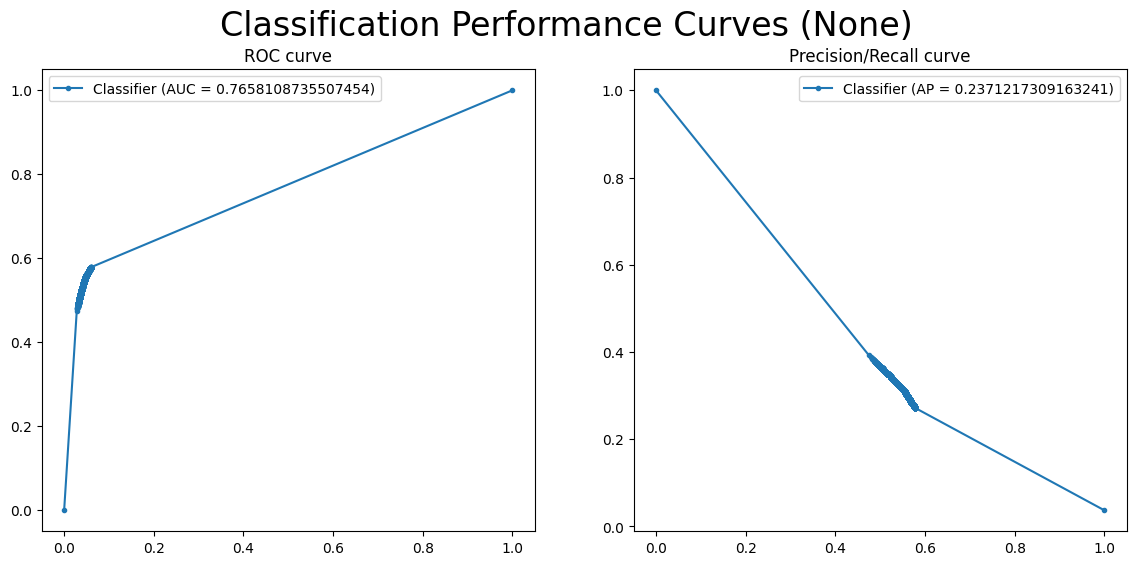

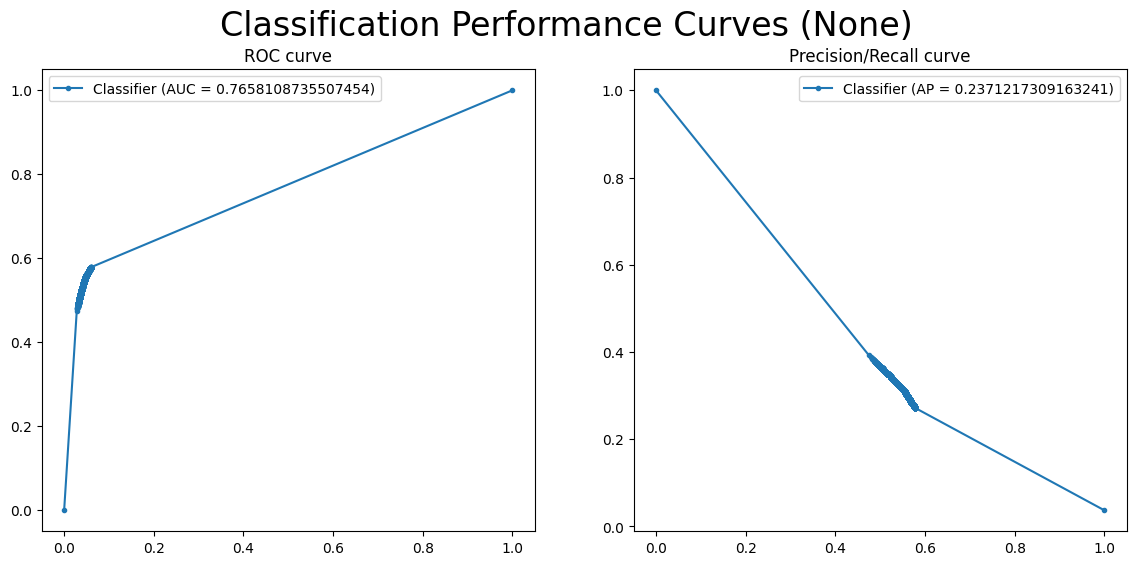

In [89]:
evaluator.plot_classification_performance(add_annotation_values=False)

# ITW

In [6]:
#true, filelist = genSpoof_list_inthewild('/mnt/f/downloads/release_in_the_wild/meta.csv')
import pandas as pd
preds = genSpoof_list('autoencoder/eval_detector_bigger_itw.out', is_itw=True)
preds_df = pd.DataFrame(preds, columns=['label', 'score'])
preds_df = preds_df.astype(float)
preds_df.shape

(32768, 2)

In [7]:
itw_evaluator = BinaryPerformance(preds_df['label'], preds_df['score'])
itw_evaluator.evaluate_binary_performance()


Performance metrics - :
                Total samples: 32768
                Positive samples: 20575.0
                Positive proportion: 0.627899169921875
                ROC AUC: 0.491
                Average Precision (PR AUC): 0.616
                EER: 0.508 (with threshold: 1.401298464324817e-45)

                With classification threshold = 0.5:
                Precision: 0.501;
                Recall: 0.043;
                F-score: 0.079;
                Accuracy: 0.372
                


,aucpr,aucroc,precision,recall,f_score,accuracy,eer
0,0.615568,0.491029,0.500568,0.042868,0.078972,0.372162,0.507518


In [11]:
itw_evaluator.set_threshold(0.05) #itw_evaluator.get_best_threshold()
itw_evaluator.evaluate_binary_performance()

Performance metrics - :
                Total samples: 32768
                Positive samples: 20575.0
                Positive proportion: 0.627899169921875
                ROC AUC: 0.491
                Average Precision (PR AUC): 0.616
                EER: 0.508 (with threshold: 1.401298464324817e-45)

                With classification threshold = 0.05:
                Precision: 0.507;
                Recall: 0.045;
                F-score: 0.082;
                Accuracy: 0.373
                


,aucpr,aucroc,precision,recall,f_score,accuracy,eer
0,0.615568,0.491029,0.507159,0.044763,0.082265,0.372894,0.507518


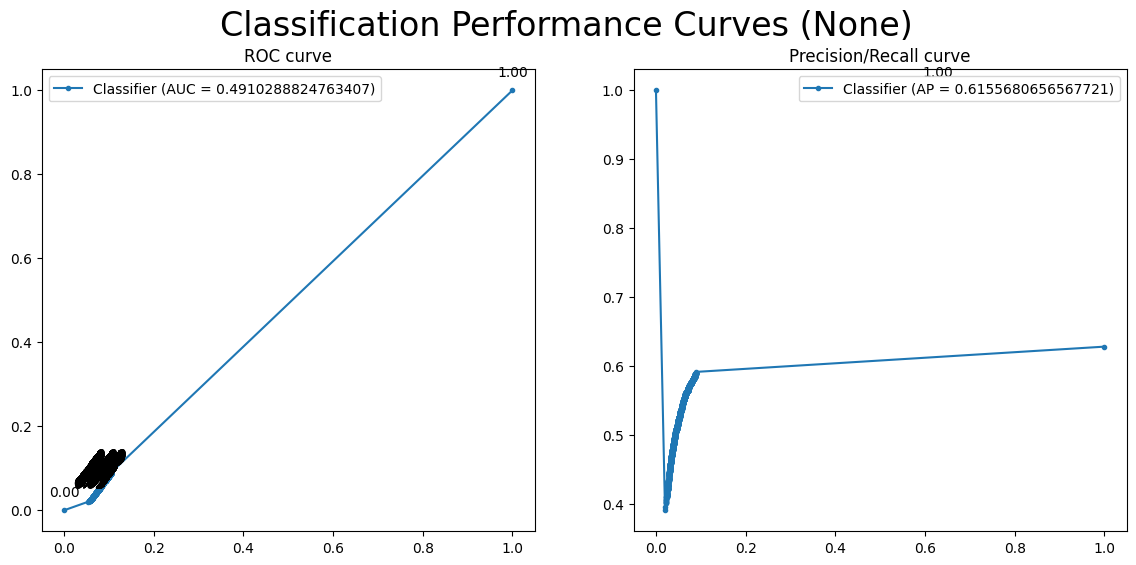

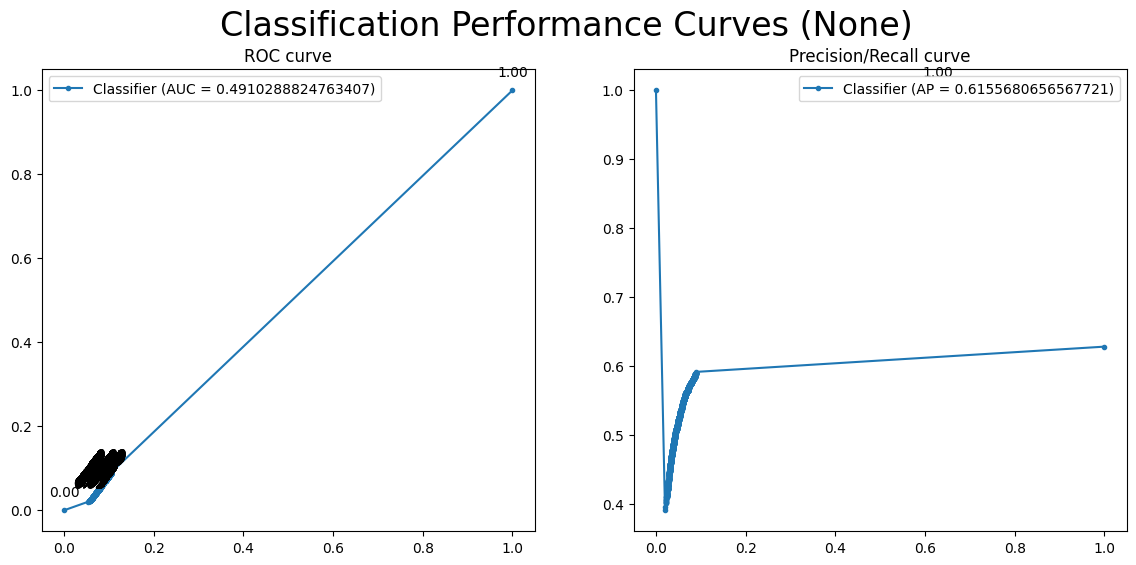

In [9]:
itw_evaluator.plot_classification_performance()